In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Activation, GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [20]:
!nvidia-smi

Tue Jan 18 15:43:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:3D:00.0 Off |                    0 |
| N/A   29C    P0    43W / 300W |  15757MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   

## 1. 下載simpson dataset

In [ ]:
# !unzip -qq Dataset/NPP_Parsing_600.zip

In [ ]:
# import os
# from PIL import Image

# data_dir = './'
# data_path = os.path.join(data_dir, '')
# data_resize_800_dir = './NPP_Parsing_600/'

# #for dir in os.listdir(data_path):
# # for img in os.listdir(data_path):
# image = Image.open(os.path.join(data_dir,'AHS25-WC.jpg'))
# new_image = image.resize((600, 600))
# new_image.save(os.path.join(data_resize_800_dir,'AHS25-WC.jpg'))


(1600, 800, 3)


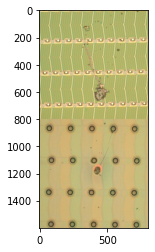

In [3]:
#將圖片轉換成陣列格式
image1 = cv2.imread('NPP_Parsing_800/AC1Q8-WT.jpg')
image2 = cv2.imread('NPP_Parsing_800/AC1Q8-WC.jpg')
image1 =cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2 =cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
imagePD = np.concatenate((image1,image2))
print(imagePD.shape)
#畫出圖片
plt.imshow(imagePD)

In [ ]:
# import os
# from PIL import Image

# def imgConcat(img_c,img_t):
#     image1 = cv2.imread('./NPP_Parsing_800/' + img_c)
#     image2 = cv2.imread('./NPP_Parsing_800/' + img_t)
#     image1 =cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
#     image2 =cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
#     imagePD = np.concatenate((image1,image2))    
#     im = Image.fromarray(imagePD)
#     im.save(os.path.join('./img_ct/', img_t[:-4]+'_CT.jpg'))
# #     im.save(os.path.join('./img_ct/', 'test.jpg'))
   


In [ ]:
# train_data['img_c'][599]

In [ ]:
# train_data['img_t'][599]

In [ ]:
# for i in range(len(train_data)):    
#     imgConcat(train_data['img_c'][i],train_data['img_t'][i])
#     print(i)

## 3. 將圖片路徑以及標籤個存取在陣列裡面

In [53]:
# 圖片大小
Shape_W =  800
Shape_H =  1600
# Batch size
batch_size =  1
# 訓練集路徑
# Trainloc = 'NPP_Parsing_800/'
# # 測試集路徑
# Testloc = 'NPP_Parsing_800/'

Trainloc = 'img_ct/'
# 測試集路徑
Testloc = 'img_ct/'
#讀入CSV
train_data = pd.read_csv("CT.csv", low_memory=False)

In [ ]:
# train_data= pd.concat([train_data_T,train_data_C],axis=1)

In [5]:
train_data['img_t']

0        AKE2-WT.jpg
1        AKE1-WT.jpg
2        AKD8-WT.jpg
3       AKBT9-WT.jpg
4      AJ3Q18-WT.jpg
           ...      
795     ACT19-WT.jpg
796      ACS9-WT.jpg
797      ACR5-WT.jpg
798     ACO25-WT.jpg
799     ACK50-WT.jpg
Name: img_t, Length: 800, dtype: object

In [6]:
train_data['img_ct'] = train_data['img_t'].str.slice(0,-4)+ '_CT.jpg'
train_data

,pred1,pred2,pred3,img_c,img_t,pred,異物側,PI,異物種類,img_ct
0,0,1,3,AKE2-WC.jpg,AKE2-WT.jpg,13,CF,下,金屬異物,AKE2-WT_CT.jpg
1,0,1,3,AKE1-WC.jpg,AKE1-WT.jpg,13,CF,下,金屬異物,AKE1-WT_CT.jpg
2,1,1,3,AKD8-WC.jpg,AKD8-WT.jpg,113,TFT,下,金屬異物,AKD8-WT_CT.jpg
3,0,1,3,AKBT9-WC.jpg,AKBT9-WT.jpg,13,CF,下,金屬異物,AKBT9-WT_CT.jpg
4,0,1,3,AJ3Q18-WC.jpg,AJ3Q18-WT.jpg,13,CF,下,金屬異物,AJ3Q18-WT_CT.jpg
...,...,...,...,...,...,...,...,...,...,...
795,1,1,0,ACT19-WC.jpg,ACT19-WT.jpg,110,TFT,下,玻璃屑,ACT19-WT_CT.jpg
796,1,1,0,ACS9-WC.jpg,ACS9-WT.jpg,110,TFT,下,玻璃屑,ACS9-WT_CT.jpg
797,1,1,0,ACR5-WC.jpg,ACR5-WT.jpg,110,TFT,下,玻璃屑,ACR5-WT_CT.jpg
798,0,1,0,ACO25-WC.jpg,ACO25-WT.jpg,10,CF,下,玻璃屑,ACO25-WT_CT.jpg


In [7]:
train_data['pred'] = train_data['pred1'].astype(str) + train_data['pred2'].astype(str) + train_data['pred3'].astype(str)
train_data

,pred1,pred2,pred3,img_c,img_t,pred,異物側,PI,異物種類,img_ct
0,0,1,3,AKE2-WC.jpg,AKE2-WT.jpg,013,CF,下,金屬異物,AKE2-WT_CT.jpg
1,0,1,3,AKE1-WC.jpg,AKE1-WT.jpg,013,CF,下,金屬異物,AKE1-WT_CT.jpg
2,1,1,3,AKD8-WC.jpg,AKD8-WT.jpg,113,TFT,下,金屬異物,AKD8-WT_CT.jpg
3,0,1,3,AKBT9-WC.jpg,AKBT9-WT.jpg,013,CF,下,金屬異物,AKBT9-WT_CT.jpg
4,0,1,3,AJ3Q18-WC.jpg,AJ3Q18-WT.jpg,013,CF,下,金屬異物,AJ3Q18-WT_CT.jpg
...,...,...,...,...,...,...,...,...,...,...
795,1,1,0,ACT19-WC.jpg,ACT19-WT.jpg,110,TFT,下,玻璃屑,ACT19-WT_CT.jpg
796,1,1,0,ACS9-WC.jpg,ACS9-WT.jpg,110,TFT,下,玻璃屑,ACS9-WT_CT.jpg
797,1,1,0,ACR5-WC.jpg,ACR5-WT.jpg,110,TFT,下,玻璃屑,ACR5-WT_CT.jpg
798,0,1,0,ACO25-WC.jpg,ACO25-WT.jpg,010,CF,下,玻璃屑,ACO25-WT_CT.jpg


In [8]:
label = {'CF':0, 
         'TFT':1}

label1 = {'上':0, 
         '下':1}

label2 = {'玻璃屑':0,
         '透明異物':1,
         '黑色異物':2, 
         '金屬異物':3}

In [ ]:
# train_data['pred3'] = train_data['pred3'].map(label2).values
# train_data

In [ ]:
# train_data['pred2'] = train_data['pred2'].map(label1).values
# train_data

In [ ]:
# train_data['pred1'] = train_data['pred1'].map(label).values
# train_data

In [9]:
df = train_data.copy()
# del df['pred2']
# del df['pred3']
df

,pred1,pred2,pred3,img_c,img_t,pred,異物側,PI,異物種類,img_ct
0,0,1,3,AKE2-WC.jpg,AKE2-WT.jpg,013,CF,下,金屬異物,AKE2-WT_CT.jpg
1,0,1,3,AKE1-WC.jpg,AKE1-WT.jpg,013,CF,下,金屬異物,AKE1-WT_CT.jpg
2,1,1,3,AKD8-WC.jpg,AKD8-WT.jpg,113,TFT,下,金屬異物,AKD8-WT_CT.jpg
3,0,1,3,AKBT9-WC.jpg,AKBT9-WT.jpg,013,CF,下,金屬異物,AKBT9-WT_CT.jpg
4,0,1,3,AJ3Q18-WC.jpg,AJ3Q18-WT.jpg,013,CF,下,金屬異物,AJ3Q18-WT_CT.jpg
...,...,...,...,...,...,...,...,...,...,...
795,1,1,0,ACT19-WC.jpg,ACT19-WT.jpg,110,TFT,下,玻璃屑,ACT19-WT_CT.jpg
796,1,1,0,ACS9-WC.jpg,ACS9-WT.jpg,110,TFT,下,玻璃屑,ACS9-WT_CT.jpg
797,1,1,0,ACR5-WC.jpg,ACR5-WT.jpg,110,TFT,下,玻璃屑,ACR5-WT_CT.jpg
798,0,1,0,ACO25-WC.jpg,ACO25-WT.jpg,010,CF,下,玻璃屑,ACO25-WT_CT.jpg


# 二、資料預處理

## 1. Train Test split

In [10]:
data_list = df

In [ ]:
# df_train = train_data.copy()
# del df_train['img_path']
# df_train

In [ ]:
# df_test = train_data.copy()
# del df_test['pred1']
# del df_test['pred2']
# del df_test['pred3']
# df_test

In [11]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                      test_size=0.2,
                      random_state=42,
                      stratify=data_list['pred'].values,
                      shuffle = True)
print(len(train_list),len(test_list))

640 160


## 2. 資料擴增Data Augmentation

In [46]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

## 3. 將要訓練的資料輸入進keras data generator裏面

In [54]:
# y_pred = ['pred1','pred2','pred3']
x_c='img_ct'
y_pred='pred'
train_datagen = ImageDataGenerator() # 訓練集資料擴增，設計你們自己資料擴增的選擇，記得rescale很重要

train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_list,
    directory = Trainloc,
    x_col = x_c,
    y_col = y_pred,
    color_mode = 'rgb',
    target_size = (Shape_W,Shape_H),
    batch_size = batch_size,
    shuffle = True,
    preprocessing_function=preprocess_input,
    class_mode = 'categorical')

test_datagen = ImageDataGenerator()  # 驗證集資料擴增，記得驗證集是否會需要資料擴增，然後有什麼必須要跟train_datagen一樣的
test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_list,
    directory = Trainloc,
    x_col = x_c,
    y_col = y_pred,
    color_mode = 'rgb',
    target_size = (Shape_W,Shape_H),
    batch_size = batch_size,
    shuffle = False,
    preprocessing_function=preprocess_input,
#     class_mode="raw",
#     class_mode = 'multi_output',
#     class_mode = 'categorical',
    class_mode = 'categorical')

Found 640 validated image filenames belonging to 16 classes.
Found 160 validated image filenames belonging to 16 classes.


In [55]:
label = train_gen.class_indices
label
# train_gen

{'000': 0,
 '001': 1,
 '002': 2,
 '003': 3,
 '010': 4,
 '011': 5,
 '012': 6,
 '013': 7,
 '100': 8,
 '101': 9,
 '102': 10,
 '103': 11,
 '110': 12,
 '111': 13,
 '112': 14,
 '113': 15}

# 三、載入預訓練模型
Use `ResNet50` for Transfer learning

## 1. 讀入模型

In [15]:
len(label)

16

In [56]:
#B7
from tensorflow.keras.layers import Input, Flatten

# from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import EfficientNetB3
with strategy.scope():

    pre_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(Shape_W, Shape_H, 3)) 

    # Do GlobalAveragePooling2D
    x = GlobalAveragePooling2D()(pre_model.output)

    x = Flatten()(x)
    # Dense layer
    x = Dense(800, activation='relu')(x)


    #Output layer
    # label = Dense(label.shape[-1], activation='sigmoid', name='label')(x)
    # label1 = Dense(label1.shape[-1], activation='sigmoid', name='label1')(x)
    # label2 = Dense(label2.shape[-1], activation='softmax', name='label2')(x)

    # label = Dense(len(label), activation='sigmoid', name='label')(x)
    # label1 = Dense(len(label1), activation='sigmoid', name='label1')(x)
    # label2 = Dense(len(label2), activation='softmax', name='label2')(x)

    pred_ct = Dense(len(label), activation='softmax', name='pred_ct')(x)

# set up a model structure#
# model = Model(inputs=pre_model.inputs, outputs= [label, label1, label2])

    model = Model(inputs=pre_model.inputs, outputs= pred_ct)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = optimizer, 
                loss = loss_fn,
                metrics='accuracy'
             )
    
model.summary()



Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 800, 1600, 3 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 800, 1600, 3) 0           input_7[0][0]                    
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, 800, 1600, 3) 7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 801, 1601, 3) 0           normalization_6[0][0]            
___________________________________________________________________________________________

In [65]:
#B7
from tensorflow.keras.layers import Input, Flatten

from tensorflow.keras.applications import EfficientNetB3 
from tensorflow.keras.applications import ResNet50 
# with strategy.scope():

#     pre_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(Shape_W, Shape_H, 3)) 

#     # Do GlobalAveragePooling2D
#     x = GlobalAveragePooling2D()(pre_model.output)

#     x = Flatten()(x)
#     # Dense layer
#     x = Dense(800, activation='relu')(x)

pre_model_c = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(800, 800, 3)) 

# Do GlobalAveragePooling2D
x1 = GlobalAveragePooling2D()(pre_model_c.output)


pre_model_t = ResNet50(weights='imagenet', include_top=False, input_shape=(800, 800, 3)) 

# Do GlobalAveragePooling2D
x2 = GlobalAveragePooling2D()(pre_model_t.output)

concatted = tf.keras.layers.Concatenate(axis=-1)([x1, x2])

x = Dense(800, activation='relu')(x)

pred_ct = Dense(len(label), activation='softmax', name='pred_ct')(x)


model = Model(inputs=[pre_model_c.inputs,pre_model_t.inputs], outputs= pred_ct)
    
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
rescaling_17 (Rescaling)        (None, 800, 800, 3)  0           input_18[0][0]                   
__________________________________________________________________________________________________
normalization_17 (Normalization (None, 800, 800, 3)  7           rescaling_17[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 801, 801, 3)  0           normalization_17[0][0]           
___________________________________________________________________________________________

## 2. 決定要Fine tune Freeze的layer
這個要判斷今天的資料集狀況再決定是否要對預訓練模型的layer做Freezing

In [57]:
model.trainable = True #每一層全打開是 fine tune

# 我們可以選擇我們要finetune的block
#從layer得名稱中，找到我們想要凍結前的layer名稱，並將這些前面的layer給Freeze起來

# for layer in model.layers[:-80]:
#     layer.trainable = False
#     print(layer.name)


In [ ]:
# model.trainable = True #每一層全打開是 fine tune

# for layer in model.layers:
#     if layer.name == 'block5i_project_conv':
#         break
#     layer.trainable = False
#     print(layer.name)

## 3. 決定 Loss function 、Optimizer

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# loss_fn = keras.losses.SparseCategoricalCrossentropy()

# me=['accuracy', "Precision", "Recall"]
# model.compile(optimizer = optimizer, 
#                loss={'label': loss_fn,
#                      'label1': loss_fn,
#                      'label2': loss_fn},
#               metrics={'label':'accuracy',
#                      'label1': 'accuracy',
#                      'label2': 'accuracy'}
# #          loss = 'sparse_categorical_crossentropy',
# #        loss = 'categorical_crossentropy', 
# #      loss = 'binary_crossentropy',
# #       metrics=['accuracy', "Precision", "Recall"]
#              )

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer = optimizer, 
                loss = loss_fn,
                metrics='accuracy'
             )

ValueError: Variable (<tf.Variable 'normalization_2/mean:0' shape=(3,) dtype=float32, numpy=array([0.485, 0.456, 0.406], dtype=float32)>) was not created in the distribution strategy scope of (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7ffbed233a60>). It is most likely due to not all layers or the model or optimizer being created outside the distribution strategy scope. Try to make sure your code looks similar to the following.
with strategy.scope():
  model=_create_model()
  model.compile(...)

## 4. 設定 Callbacks Function

In [58]:
model_dir = './model-logs/B3_CT_800_0118_01'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# save model
modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = tf.keras.callbacks.ModelCheckpoint(modelfiles,
                          monitor='val_accuracy',
                          save_best_only=True)
# set earlystop
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                        patience=5,
                        verbose=1)



from tensorflow.keras.callbacks import ReduceLROnPlateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

callbacks_list = [model_mckp,earlystop,reduceLR]

## 5. 開始訓練囉！

In [37]:
# Open a strategy scope.
with strategy.scope():
  # Everything that creates variables should be under the strategy scope.
  # In general this is only model construction & `compile()`.
#     model = Model(Model(inputs=pre_model.inputs, outputs= pred_ct))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
                loss = keras.losses.SparseCategoricalCrossentropy(),
                metrics='accuracy')

ValueError: Variable (<tf.Variable 'normalization_1/mean:0' shape=(3,) dtype=float32, numpy=array([0.485, 0.456, 0.406], dtype=float32)>) was not created in the distribution strategy scope of (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7ffbed233a60>). It is most likely due to not all layers or the model or optimizer being created outside the distribution strategy scope. Try to make sure your code looks similar to the following.
with strategy.scope():
  model=_create_model()
  model.compile(...)

In [30]:
!nvidia-smi

Tue Jan 18 16:01:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:3D:00.0 Off |                    0 |
| N/A   29C    P0    43W / 300W |  15977MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   

In [59]:
# train_cols = ['img_path']
# y_train_cols = ['pred1','pred2','pred3']
# label, label1, label2

# Epoch
Epoch =  100

#Training
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=test_gen.n//test_gen.batch_size

history = model.fit(train_gen,
          steps_per_epoch=STEP_SIZE_TRAIN,
          epochs = Epoch, 
          shuffle = True, 
          callbacks=callbacks_list, 
          validation_data=test_gen,
          validation_steps=STEP_SIZE_VALID,)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node div_no_nan_1/AddN_1/_3222}}]]
	 [[div_no_nan_1/ReadVariableOp_4/_3212]] [Op:__inference_train_function_812955]

Function call stack:
train_function


In [27]:
!nvidia-smi

Tue Jan 18 15:55:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:3D:00.0 Off |                    0 |
| N/A   29C    P0    43W / 300W |  15977MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   

# 四、查看模型訓練結果

In [ ]:
training_loss, val_loss = history.history['loss'], history.history['val_loss']

plt.title('Loss')
plt.plot(training_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.show()

training_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

plt.title('ACC')
plt.plot(training_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.show()

# 五、測試模型
在訓練好模型後，我們一定會拿測試集來測試一下我們訓練模型的好壞

現在就是要使用kaggle_simpson_testset來進行預測

## 1. 將預測的資料集讀取下來，並轉換成dataframe形式
** 會全部先設定class為1是因為我們不知道標籤，所以先預設為1 **

In [ ]:
#讀取圖片與 Label
data_dir = './'
testing_dir_path = os.path.join(data_dir, 'Dataset/test')
test_df = pd.DataFrame({'file_path':[str(id)+'.jpg' for id in range(3001)],'class':1}) 
test_df

## 2. 將測試集的dataframe放入keras data generator中

In [ ]:
tgen = ImageDataGenerator()
test_gen = tgen.flow_from_dataframe(dataframe = test_df,
                                    directory = Testloc,
                                    x_col = 'file_path',
                                    y_col = 'class',
                                    color_mode='rgb',
                                    target_size = (Shape,Shape),
                                    batch_size = batch_size,
                                    class_mode = None,
                                    shuffle=False,
                                    preprocessing_function=preprocess_input)

y_pred = model.predict(test_gen).argmax(-1)

In [ ]:
y_pred

In [ ]:
test_df

In [ ]:
test_df['class'] =y_pred
test_df

# 六、評估模型

In [ ]:
mapping_label = {0:'buildings', 
             1:'forest',
            2:'glacier',
            3:'mountain',
            4:'sea',
            5:'street'}

In [ ]:
test_df['class'] = test_df['class'].map(mapping_label).values
test_df

In [ ]:
# 將訓練好的model運用test data 進行predict，並將結果上傳到kaggle
ans = pd.read_csv('./Dataset/sample_submission.csv',index_col=0)
ans['Label'] = test_df['class']
ans.to_csv('submission_20211229_05.csv', index=True)